In [1]:
import numpy as np
from enviroment import Env
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from util import getAction, monteCarlo, plotValueFunction
%matplotlib inline 

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def cal_feature(state, action):
    feature = np.ones([3, 6, 2])
    x, y = state
    feature[:, :, 1 - action] = 0
    x_space = [[1, 4], [4, 7], [7, 10]]
    y_space = [[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]]
    for i in range(len(x_space)):
        if x < x_space[i][0] or x > x_space[i][1]:
            feature[i, :, :] = 0
    for i in range(len(y_space)):
        if y < y_space[i][0] or y > y_space[i][1]:
            feature[:, i, :] = 0
    return feature.flatten()

In [5]:
def cal_action(state, theta, e):
    # choose action using epsilon-greedy exploration
    if np.random.uniform(0, 1) > e:
        q0 = cal_q(state, 0, theta)
        q1 = cal_q(state, 1, theta)
        if q0 > q1:
            action = 0
        else:
            action = 1
    else:
        action = np.random.randint(0, 2)
    return action

In [6]:
def cal_q(state, action, theta):
    feature = cal_feature(state, action)
    q = np.matmul(feature, theta)
    return q

In [7]:
def q_gradient(state, action):
    return cal_feature(state, action)

In [8]:
def cal_q_table(theta):
    Q = np.zeros([10, 21, 2])
    for i in range(10):
        for j in range(21):
            for k in range(2):
                Q[i, j, k] = cal_q([i + 1, j + 1], k, theta)
    return Q

In [19]:
def linear_approx_sarsa(max_episode, alpha, e, gamma, lbd, optimal_Q=None):
    theta = np.random.randn(36) / 100
    mse = []
    for i in range(max_episode):
        # initial eligibility traces
        E = np.zeros([36,])
        # initial a new episode
        episode = Env()
        x, y = episode.getCurrentState()
        action = cal_action([x, y], theta, e)
        # sample until terminal
        while not episode.isGameOver():
            # run one step
            ([xp, yp], reward) = episode.step((x, y), action)
            if episode.isGameOver():
                # if the episode is in terminal state, Q[s', a'] is 0
                q0 = cal_q([x, y], action, theta)
                delta = reward - q0 
                actionp = 0
            else:
                actionp = cal_action([xp, yp], theta, e)
                q0 = cal_q([x, y], action, theta)
                q1 = cal_q([xp, yp], actionp, theta)
                delta = reward + gamma * q1 - q0 
            E = E * (gamma * lbd) + q_gradient([x, y], action)
            theta += (alpha * delta * E)
            x, y, action = xp, yp, actionp 
        if (i % 1000 == 0) and (optimal_Q is not None):
            mse.append(np.sum((cal_q_table(theta) - optimal_Q)**2))
    return (theta, mse)

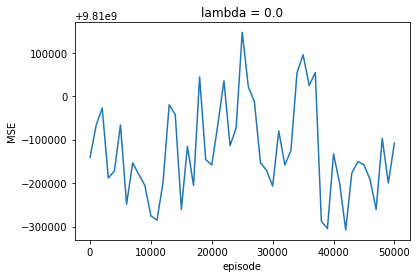

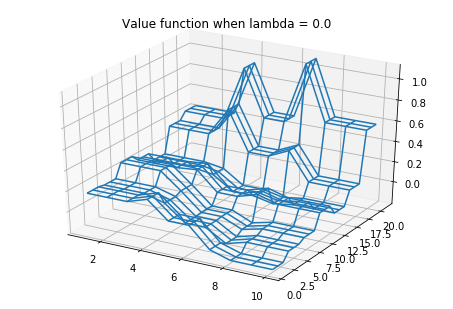

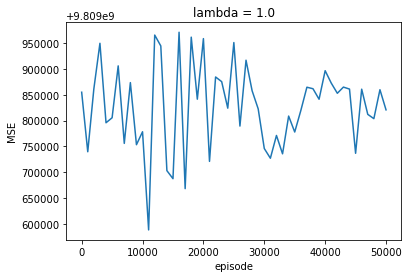

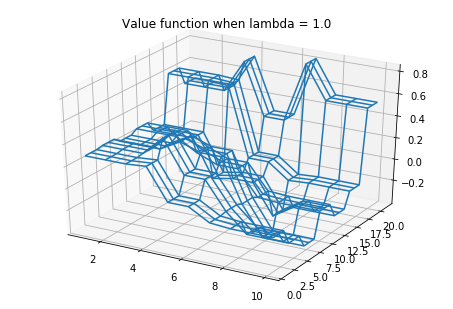

In [20]:
N0 = 200
e = 0.05
alpha = 0.01
gamma = 1
max_episode = 50001
mse_list = []
#mc_Q = monteCarlo(10**6, N0)
for lbd in np.arange(0, 1.1, 0.1):
    theta, mse = linear_approx_sarsa(max_episode, alpha, e, gamma, lbd, mc_Q)
    mse_list.append(mse[-1])
    lfp_Q = cal_q_table(theta)
    Vm = np.amax(lfp_Q, axis=2)
    if lbd == 0.0 or lbd == 1.0:
        # plot MSE against episode number
        plt.figure()
        plt.plot(np.arange(0, max_episode, 1000), mse)
        plt.xlabel("episode")
        plt.ylabel("MSE")
        plt.title("lambda = {}".format(lbd))
        plt.draw()
        # plot value function
        x = np.arange(1, 11)
        y = np.arange(1, 22)
        xs, ys = np.meshgrid(x, y)
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.plot_wireframe(xs, ys, Vm.T, rstride=1, cstride=1)
        plt.title("Value function when lambda = {}".format(lbd))
        plt.draw()

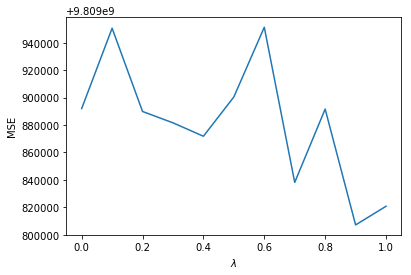

In [21]:
plt.figure()
plt.plot(np.arange(0, 1.1, 0.1), mse_list)
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
plt.draw()